### Imports

In [24]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras.models import load_model

In [25]:
print(tf.config.list_physical_devices('GPU'))

[]


## Creating annotations
First we need to transform our Yolo labels dataset into a csv file

In [26]:
# Iterate over each label file in the labels folder
def create_csv_annotations(images_folder, labels_folder, name):
    annotations = []
    image_width = 224
    image_height = 224

    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_folder, label_file), 'r') as f:
                lines = f.readlines()
            
            image_name = os.path.splitext(label_file)[0] + '.jpg'
            image_path = os.path.join(images_folder, image_name)
            
            for line in lines:
                class_label, x_center, y_center, width, height = map(float, line.split())
                x_min = (x_center - width / 2)
                y_min = (y_center - height / 2)
                x_max = (x_center + width / 2)
                y_max = (y_center + height / 2)
                
                annotations.append([image_path, x_min, y_min, x_max, y_max, image_width, image_height, class_label])

        # Here we create a DataFrame from annotations list and then we convert the df into a csv file
        df = pd.DataFrame(annotations, columns=['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'width', 'height', 'label'])
        df.to_csv(name, index=False)

In [27]:
create_csv_annotations('images/train', 'labels/train', 'annotations_train.csv')

In [28]:
create_csv_annotations('images/test', 'labels/test', 'annotations_test.csv')

In [29]:
create_csv_annotations('images/val', 'labels/val', 'annotations_val.csv')

### Transforming the csv annotations to arrays required by TensorFlow

In [30]:
train_annotations = pd.read_csv('annotations_train.csv')
val_annotations = pd.read_csv('annotations_val.csv')
test_annotations = pd.read_csv('annotations_test.csv')

In [31]:


#train_annotations, val_annotations = train_test_split(annotations, test_size=0.2, random_state=42)

# The 224 x 224 input is required because -> this is because vast majority of pretrained TF models
# were trained using that input
input_shape = (224, 224, 3)  # height, width, depth (this is the # of color channels RGB = 3)

# Function to preprocess image and annotations
# the annotations are still not in the format required for TF
def preprocess_data(annotation):
    image = load_img(annotation['img_path'], target_size=(input_shape[0], input_shape[1]))
    image_array = img_to_array(image)
    image_array /= 255.0
    bbox = [annotation['xmin'], annotation['ymin'], annotation['xmax'], annotation['ymax']]
    label = annotation['label']
    return image_array, bbox, label

train_data = train_annotations.apply(preprocess_data, axis=1)
val_data = val_annotations.apply(preprocess_data, axis=1)
test_data = test_annotations.apply(preprocess_data, axis=1)

# Convert preprocessed data into arrays -> this is the format needed for TF
X_train, y_train_bbox, y_train_label = zip(*train_data)
X_val, y_val_bbox, y_val_label = zip(*val_data)
X_test, y_test_bbox, y_test_label = zip(*test_data)

# Convert lists to numpy arrays
X_train = tf.convert_to_tensor(X_train)
y_train_bbox = tf.convert_to_tensor(y_train_bbox)
y_train_label = tf.convert_to_tensor(y_train_label)
X_val = tf.convert_to_tensor(X_val)
y_val_bbox = tf.convert_to_tensor(y_val_bbox)
y_val_label = tf.convert_to_tensor(y_val_label)
X_test = tf.convert_to_tensor(X_test)
y_test_bbox = tf.convert_to_tensor(y_test_bbox)
y_test_label = tf.convert_to_tensor(y_test_label)


Here we are checking that the shapes of the images[0] and labels are the same

In [32]:
len(X_train)

5944

In [18]:
y_train_bbox

<tf.Tensor: shape=(2776, 4), dtype=float32, numpy=
array([[0.5261985, 0.2484605, 0.9944255, 0.5728955],
       [0.005574 , 0.2525665, 0.526198 , 0.9527715],
       [0.0011145, 0.9486655, 0.0746935, 0.9856265],
       ...,
       [0.3500555, 0.6468175, 0.9520625, 0.8377825],
       [0.4370125, 0.392197 , 0.6544035, 0.620123 ],
       [0.620959 , 0.412731 , 0.812709 , 0.620123 ]], dtype=float32)>

In [33]:
X_train.shape

TensorShape([5944, 224, 224, 3])

In [34]:
y_train_label.shape

TensorShape([5944])

In [27]:
y_train_bbox.shape

TensorShape([2776, 4])

In [35]:
len(X_val)

898

In [36]:
len(X_test)

1555

In [37]:
y_test_label.shape

TensorShape([1555])

## Concepts to wrap your head around the next models

[Tensor flow intro -> Why sequential](https://towardsdatascience.com/a-comprehensive-introduction-to-tensorflows-sequential-api-and-model-for-deep-learning-c5e31aee49fa#:~:text=The%20sequential%20model%20allows%20us,for%20building%20deep%20learning%20models.): Here we have a more in depth explanation of what we are actually doing when adding layers to the model.Sequential and what that means. All of the following models work based on that cause we are training neural networks.

[Input and output shapes for CNN](https://towardsdatascience.com/understanding-input-and-output-shapes-in-convolution-network-keras-f143923d56ca): This can help you understand why the value behind our input_shape and a bit more about the CNNs

[Types of Convolutions in Deep Learning](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d): Here we have some types of convolutions used by some of the next models. For example, MobileNetV2 uses depthwise separable convolutions, and those are explained here.

[But What is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA):
In case you really want to understand the basics and what a convolution really is.

## First model

[Basics of the R-CNN model](https://towardsdatascience.com/object-detection-explained-r-cnn-a6c813937a76)

In [ ]:
# This is the RCNN model, this is just base model for testing
def create_rcnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),#batch_input_shape (if you wanted to give the batch_size)
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(), # Here we are basically changing the 4D output of the CNN to 2D so that we can use Dense
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax', name='classifier_output')
    ])
    return model

# Number of classes
num_classes = train_annotations['label'].nunique()

# Create an instance of the R-CNN model
rcnn_model = create_rcnn_model(input_shape, num_classes)

# Compile the model with appropriate losses and metrics
rcnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
rcnn_model.fit(X_train, y_train_label, validation_data=(X_test, y_test_label), epochs=10)

## RCNN With MobileNetV2

[What is MobileNetV2](https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5)

In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [38]:
def create_rcnn_MovileNetV2(input_shape, num_classes):
    
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Additional convolutional layers with reduced kernel size
    conv_layers = models.Sequential([ #Without the padding / strides I get dimensionality errors :(
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Add padding to maintain spatial dimensions
        layers.MaxPooling2D((2, 2), strides=(1, 1)),  # Reduce the pooling stride
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add padding to maintain spatial dimensions
        layers.MaxPooling2D((2, 2), strides=(1, 1)),  # Reduce the pooling stride
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add padding to maintain spatial dimensions
    ])
    
    top_layers = models.Sequential([
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax', name='classifier_output')
    ])
    
    # Combine the base ResNet model, additional convolutional layers, and top layers
    model = models.Sequential([
        base_model,
        conv_layers,
        top_layers
    ])
    
    return model

# Number of classes
num_classes = train_annotations['label'].nunique()

input_shape = (224, 224, 3)  # 224 is the one used by ResNet
rcnn_resnet_model = create_rcnn_MovileNetV2(input_shape, num_classes)

rcnn_resnet_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rcnn_resnet_model.fit(X_train, y_train_label, validation_data=(X_test, y_test_label), epochs=15)


Epoch 1/15
87/87 [==============================] - 277s 3s/step - loss: 0.7821 - accuracy: 0.7003 - val_loss: 1.1293 - val_accuracy: 0.6752
Epoch 2/15
87/87 [==============================] - 257s 3s/step - loss: 0.6065 - accuracy: 0.7720 - val_loss: 0.9024 - val_accuracy: 0.6822
Epoch 3/15
87/87 [==============================] - 257s 3s/step - loss: 0.6084 - accuracy: 0.7622 - val_loss: 3.2185 - val_accuracy: 0.1281
Epoch 4/15
87/87 [==============================] - 257s 3s/step - loss: 0.5777 - accuracy: 0.7741 - val_loss: 1.2873 - val_accuracy: 0.2352
Epoch 5/15
87/87 [==============================] - 260s 3s/step - loss: 0.5349 - accuracy: 0.7878 - val_loss: 1.9865 - val_accuracy: 0.2421
Epoch 6/15
87/87 [==============================] - 257s 3s/step - loss: 0.5108 - accuracy: 0.7947 - val_loss: 3.5161 - val_accuracy: 0.3725
Epoch 7/15
87/87 [==============================] - 256s 3s/step - loss: 0.5183 - accuracy: 0.7918 - val_loss: 0.9597 - val_accuracy: 0.6694
Epoch 8/15
87

In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(rcnn_resnet_model.predict(X_val), axis=1)

y_val_label = np.array(y_val_label, dtype=int)
y_pred = np.array(y_pred, dtype=int)

target_names = ['Vehiculos', 'Construcciones', 'Vias', 'Rios', 'Mineria']  # Get unique class labels
print(classification_report(y_val_label, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_val_label, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

14/14 [==============================] - 7s 525ms/step
                precision    recall  f1-score   support

     Vehiculos       0.00      0.00      0.00         3
Construcciones       0.80      0.93      0.86       254
          Vias       0.73      0.39      0.51        98
          Rios       0.67      0.83      0.74        60
       Mineria       0.00      0.00      0.00         9

      accuracy                           0.77       424
     macro avg       0.44      0.43      0.42       424
  weighted avg       0.74      0.77      0.74       424

Confusion Matrix:
[[  0   0   0   3   0]
 [  0 237   5  12   0]
 [  0  55  38   5   0]
 [  0   3   7  50   0]
 [  0   2   2   5   0]]


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [75]:
rcnn_resnet_model.save("saved_models/rcnn_resnet_model.h5")

c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
loaded_model = load_model("saved_models/rcnn_resnet_model.h5")
#loaded_model is now the name of the model and the model per se
#as example, in the next cell, y_pred now uses loaded_model

In [78]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(loaded_model.predict(X_val), axis=1)

y_val_label = np.array(y_val_label, dtype=int)
y_pred = np.array(y_pred, dtype=int)

target_names = ['Vehiculos', 'Construcciones', 'Vias', 'Rios', 'Mineria']  # Get unique class labels
print(classification_report(y_val_label, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_val_label, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

14/14 [==============================] - 10s 543ms/step
                precision    recall  f1-score   support

     Vehiculos       0.00      0.00      0.00         3
Construcciones       0.80      0.93      0.86       254
          Vias       0.73      0.39      0.51        98
          Rios       0.67      0.83      0.74        60
       Mineria       0.00      0.00      0.00         9

      accuracy                           0.77       424
     macro avg       0.44      0.43      0.42       424
  weighted avg       0.74      0.77      0.74       424

Confusion Matrix:
[[  0   0   0   3   0]
 [  0 237   5  12   0]
 [  0  55  38   5   0]
 [  0   3   7  50   0]
 [  0   2   2   5   0]]


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Resnet152
This one is the deepest variant of ResNet providing 152 layers

In [38]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models

In [39]:
def create_resnet152_model(input_shape, num_classes):
    # Load pre-trained ResNet152V2 model without the top classification layer
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    top_layers = models.Sequential([
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Combine the base model with custom classification head
    model = models.Sequential([
        base_model,
        top_layers
    ])

    return model

input_shape = (224, 224, 3)  # Input shape for ResNet152V2
num_classes = train_annotations['label'].nunique()

# Create the ResNet152 model
resnet152_model = create_resnet152_model(input_shape, num_classes)

# Compile the model
resnet152_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet152_model.fit(X_train, y_train_label, validation_data=(X_test, y_test_label), epochs=10, batch_size=32)

# Print model summary
resnet152_model.summary()

Epoch 1/10
186/186 [==============================] - 779s 4s/step - loss: 0.8910 - accuracy: 0.6798 - val_loss: 0.7781 - val_accuracy: 0.6965
Epoch 2/10
186/186 [==============================] - 725s 4s/step - loss: 0.7092 - accuracy: 0.7315 - val_loss: 0.7147 - val_accuracy: 0.7125
Epoch 3/10
186/186 [==============================] - 721s 4s/step - loss: 0.6399 - accuracy: 0.7490 - val_loss: 0.7059 - val_accuracy: 0.7209
Epoch 4/10
186/186 [==============================] - 724s 4s/step - loss: 0.6107 - accuracy: 0.7576 - val_loss: 0.6637 - val_accuracy: 0.7325
Epoch 5/10
186/186 [==============================] - 748s 4s/step - loss: 0.5887 - accuracy: 0.7648 - val_loss: 0.6852 - val_accuracy: 0.7338
Epoch 6/10
186/186 [==============================] - 736s 4s/step - loss: 0.5694 - accuracy: 0.7638 - val_loss: 0.6655 - val_accuracy: 0.7286
Epoch 7/10
186/186 [==============================] - 729s 4s/step - loss: 0.5481 - accuracy: 0.7715 - val_loss: 0.6753 - val_accuracy: 0.7280

In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(resnet152_model.predict(X_val), axis=1)

y_val_label = np.array(y_val_label, dtype=int)
y_pred = np.array(y_pred, dtype=int)

target_names = ['Vehiculos', 'Construcciones', 'Vias', 'Rios', 'Mineria']  # Get unique class labels
print(classification_report(y_val_label, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_val_label, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

29/29 [==============================] - 91s 3s/step
                precision    recall  f1-score   support

     Vehiculos       0.83      0.23      0.36        44
Construcciones       0.81      0.81      0.81       428
          Vias       0.57      0.37      0.45       131
          Rios       0.68      0.92      0.78       239
       Mineria       0.58      0.50      0.54        56

      accuracy                           0.73       898
     macro avg       0.70      0.57      0.59       898
  weighted avg       0.73      0.73      0.71       898

Confusion Matrix:
[[ 10  19   0   5  10]
 [  0 348  29  43   8]
 [  0  44  48  39   0]
 [  0  10   7 220   2]
 [  2   8   0  18  28]]


In [41]:
resnet152_model.save("saved_models/resnet152_model.h5")

c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
resnet152_model = load_model("saved_models/resnet152_model.h5")

In [14]:
#bounding_boxes = extrax

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1,
       2, 2, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [43]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(resnet152_model.predict(X_val), axis=1)

y_val_label = np.array(y_val_label, dtype=int)
y_pred = np.array(y_pred, dtype=int)

target_names = ['Vehiculos', 'Construcciones', 'Vias', 'Rios', 'Mineria']  # Get unique class labels
print(classification_report(y_val_label, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_val_label, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

29/29 [==============================] - 94s 3s/step
                precision    recall  f1-score   support

     Vehiculos       0.83      0.23      0.36        44
Construcciones       0.81      0.81      0.81       428
          Vias       0.57      0.37      0.45       131
          Rios       0.68      0.92      0.78       239
       Mineria       0.58      0.50      0.54        56

      accuracy                           0.73       898
     macro avg       0.70      0.57      0.59       898
  weighted avg       0.73      0.73      0.71       898

Confusion Matrix:
[[ 10  19   0   5  10]
 [  0 348  29  43   8]
 [  0  44  48  39   0]
 [  0  10   7 220   2]
 [  2   8   0  18  28]]


## EfficientNet

In [47]:
from efficientnet.tfkeras import EfficientNetB6

In [55]:
def create_efficientnet_b6(input_shape, num_classes):
    # Load pre-trained EfficientNet-B6 model without the top classification layer
    base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    #  Custom classification head
    top_layers = models.Sequential([
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Here we combine the base model with our custom classification head
    model = models.Sequential([
        base_model,
        top_layers
    ])

    return model

input_shape = (224, 224, 3)  # Input shape for EfficientNet-B6
num_classes = train_annotations['label'].nunique() 

# Create the EfficientNet-B6 model
efficientnet_b6_model = create_efficientnet_b6(input_shape, num_classes)

# Compile the model - sparse_cc instead of cc is needed otherwise I get ValueError: Shapes (None, 1) and (None, 5) are incompatible
efficientnet_b6_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

efficientnet_b6_model.fit(X_train, y_train_label, validation_data=(X_test, y_test_label), epochs=10, batch_size=32)


efficientnet_b6_model.summary()

Epoch 1/10
87/87 [==============================] - 500s 5s/step - loss: 0.7760 - accuracy: 0.6985 - val_loss: 0.5469 - val_accuracy: 0.7707
Epoch 2/10
87/87 [==============================] - 464s 5s/step - loss: 0.6127 - accuracy: 0.7579 - val_loss: 0.4963 - val_accuracy: 0.8021
Epoch 3/10
87/87 [==============================] - 458s 5s/step - loss: 0.5841 - accuracy: 0.7684 - val_loss: 0.4788 - val_accuracy: 0.7893
Epoch 4/10
87/87 [==============================] - 458s 5s/step - loss: 0.5671 - accuracy: 0.7759 - val_loss: 0.4654 - val_accuracy: 0.7986
Epoch 5/10
87/87 [==============================] - 460s 5s/step - loss: 0.5352 - accuracy: 0.7767 - val_loss: 0.4644 - val_accuracy: 0.8114
Epoch 6/10
87/87 [==============================] - 457s 5s/step - loss: 0.5342 - accuracy: 0.7857 - val_loss: 0.4719 - val_accuracy: 0.7998
Epoch 7/10
87/87 [==============================] - 463s 5s/step - loss: 0.5195 - accuracy: 0.7885 - val_loss: 0.4472 - val_accuracy: 0.8184
Epoch 8/10
87

In [58]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(efficientnet_b6_model.predict(X_val), axis=1)

y_val_label = np.array(y_val_label, dtype=int)
y_pred = np.array(y_pred, dtype=int)

target_names = ['Vehiculos', 'Construcciones', 'Vias', 'Rios', 'Mineria']  # Get unique class labels
print(classification_report(y_val_label, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_val_label, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

14/14 [==============================] - 61s 4s/step
                precision    recall  f1-score   support

     Vehiculos       0.40      0.67      0.50         3
Construcciones       0.82      0.98      0.89       254
          Vias       0.84      0.50      0.63        98
          Rios       0.93      0.90      0.92        60
       Mineria       0.50      0.11      0.18         9

      accuracy                           0.83       424
     macro avg       0.70      0.63      0.62       424
  weighted avg       0.83      0.83      0.82       424

Confusion Matrix:
[[  2   1   0   0   0]
 [  2 248   3   0   1]
 [  0  45  49   4   0]
 [  0   1   5  54   0]
 [  1   6   1   0   1]]


In [80]:
efficientnet_b6_model.save("saved_models/efficientnet_b6_model.h5")

In [9]:
efficientnet_b6_model = load_model("saved_models/efficientnet_b6_model.h5")

ValueError: Unknown layer: 'FixedDropout'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

## DenseNet

In [56]:
from tensorflow.keras import layers, models

In [57]:
def create_densenet_264(input_shape, num_classes):
    base_model = tf.keras.applications.DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    top_layers = models.Sequential([
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model = models.Sequential([
        base_model,
        top_layers
    ])

    return model

input_shape = (224, 224, 3) 
num_classes = train_annotations['label'].nunique()

# Create the DenseNet-264 model
densenet_264_model = create_densenet_264(input_shape, num_classes)

# Compile the model
densenet_264_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

densenet_264_model.fit(X_train, y_train_label, validation_data=(X_test, y_test_label), epochs=10, batch_size=32)

densenet_264_model.summary()

Epoch 1/10
87/87 [==============================] - 343s 4s/step - loss: 0.7905 - accuracy: 0.7061 - val_loss: 0.5361 - val_accuracy: 0.8033
Epoch 2/10
87/87 [==============================] - 326s 4s/step - loss: 0.5888 - accuracy: 0.7677 - val_loss: 0.5133 - val_accuracy: 0.7905
Epoch 3/10
87/87 [==============================] - 330s 4s/step - loss: 0.5415 - accuracy: 0.7770 - val_loss: 0.4785 - val_accuracy: 0.8079
Epoch 4/10
87/87 [==============================] - 331s 4s/step - loss: 0.5105 - accuracy: 0.7947 - val_loss: 0.4587 - val_accuracy: 0.8079
Epoch 5/10
87/87 [==============================] - 332s 4s/step - loss: 0.4974 - accuracy: 0.7929 - val_loss: 0.4375 - val_accuracy: 0.8219
Epoch 6/10
87/87 [==============================] - 332s 4s/step - loss: 0.4942 - accuracy: 0.8012 - val_loss: 0.4583 - val_accuracy: 0.8102
Epoch 7/10
87/87 [==============================] - 327s 4s/step - loss: 0.4748 - accuracy: 0.8069 - val_loss: 0.4257 - val_accuracy: 0.8219
Epoch 8/10
87

In [59]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(densenet_264_model.predict(X_val), axis=1)

y_val_label = np.array(y_val_label, dtype=int)
y_pred = np.array(y_pred, dtype=int)

target_names = ['Vehiculos', 'Construcciones', 'Vias', 'Rios', 'Mineria']  # Get unique class labels
print(classification_report(y_val_label, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_val_label, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

14/14 [==============================] - 44s 3s/step
                precision    recall  f1-score   support

     Vehiculos       0.00      0.00      0.00         3
Construcciones       0.80      0.98      0.88       254
          Vias       0.89      0.41      0.56        98
          Rios       0.93      0.90      0.92        60
       Mineria       0.55      0.67      0.60         9

      accuracy                           0.82       424
     macro avg       0.63      0.59      0.59       424
  weighted avg       0.83      0.82      0.80       424

Confusion Matrix:
[[  0   3   0   0   0]
 [  0 249   0   0   5]
 [  0  54  40   4   0]
 [  0   1   5  54   0]
 [  0   3   0   0   6]]


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [81]:
densenet_264_model.save("saved_models/densenet_264_model.h5")

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [ ]:
y_pred_reshaped = y_pred.reshape(-1, 1) 
conf_scores = np.max(y_pred_reshaped, axis=1)  

sorted_indices = np.argsort(conf_scores)[::-1]
sorted_conf_scores = conf_scores[sorted_indices]

precisions = []
recalls = []

for class_label in range(5):
    class_precisions = []
    class_recalls = []
    for threshold in sorted_conf_scores:
        threshold_mask = conf_scores >= threshold
        y_pred_threshold = y_pred_reshaped[threshold_mask]
        y_true_threshold = y_val_label[threshold_mask]
        precision = precision_score(y_true_threshold == class_label, y_pred_threshold == class_label)
        recall = recall_score(y_true_threshold == class_label, y_pred_threshold == class_label)
        class_precisions.append(precision)
        class_recalls.append(recall)
    
    precisions.append(class_precisions)
    recalls.append(class_recalls)

plt.figure(figsize=(10, 6))
for class_label in range(5):
    plt.plot(recalls[class_label], precisions[class_label], label=f'Class {class_label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()

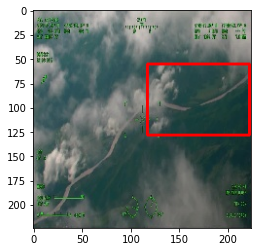

In [5]:
sample_data = train_annotations.iloc[0]
image = cv2.imread(sample_data['img_path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Coordenadas desnormalizadas para visualización
x_min = int(sample_data['xmin'] * sample_data['width'])
x_max = int(sample_data['xmax'] * sample_data['width'])
y_min = int(sample_data['ymin'] * sample_data['height'])
y_max = int(sample_data['ymax'] * sample_data['height'])

cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

plt.imshow(image)
plt.show()

In [17]:
def create_ssd_model(input_shape, num_classes, num_boxes=4):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    extra_layers = [
        layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'),
    ]

    prediction_layers = [
        layers.Conv2D(num_boxes * (num_classes + 4), kernel_size=3, padding='same'),  
        layers.Conv2D(num_boxes * num_classes, kernel_size=3, padding='same'), 
    ]

    model = models.Sequential([
        base_model,
        *extra_layers,
        *prediction_layers
    ])

    return model

input_shape = (224, 224, 3) 
num_classes = train_annotations['label'].nunique()
ssd_model = create_ssd_model(input_shape, num_classes)

ssd_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape y_train_label and y_test_label to match the expected shape
# y_train_label and y_test_label should have shape (batch_size, num_boxes, num_classes)
y_train_label = np.expand_dims(y_train_label, axis=1)
y_test_label = np.expand_dims(y_test_label, axis=1)

ssd_model.fit(X_train, y_train_label, validation_data=(X_test, y_test_label), epochs=10, batch_size=32)

ssd_model.summary()

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 193, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 567, in run_forever
      self._run_once()
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1855, in _run_once
      handle._run()
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\ioloop.py", line 685, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\ioloop.py", line 738, in _run_callback
      ret = callback()
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 825, in inner
      self.ctx_run(self.run)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 786, in run
      yielded = self.gen.send(value)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2877, in run_cell
      result = self._run_cell(
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2923, in _run_cell
      return runner(coro)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3146, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\juank\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-17-556e252d903a>", line 33, in <module>
      ssd_model.fit(X_train, y_train_label, validation_data=(X_test, y_test_label), epochs=10, batch_size=32)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [128,20] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_64909]

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

flatten = layers.Flatten()(base_model.output)

num_classes = train_annotations['label'].nunique()

classification_head = layers.Dense(256, activation='relu')(flatten)
classification_head = layers.Dropout(0.5)(classification_head)
classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(classification_head)

# Add bounding box regression head
regression_head = layers.Dense(256, activation='relu')(flatten)
regression_head = layers.Dropout(0.5)(regression_head)
regression_output = layers.Dense(4, activation='linear', name='regression_output')(regression_head)

# Create the model
model = models.Model(inputs=base_model.input, outputs=[classification_output, regression_output])

# Compile the model
model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 'regression_output': 'mean_squared_error'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mse'})

# Train the model
model.fit(X_train, {'classification_output': y_train_label, 'regression_output': y_train_bbox}, 
          validation_data=(X_val, {'classification_output': y_test_label, 'regression_output': y_test_bbox}), 
          epochs=10, batch_size=32)

#losses = rcnn_model.evaluate(X_test, [y_rpn_cls_test, y_rpn_reg_test, y_cls_test, y_reg_test])
#print("Total Loss:", sum(losses))

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 11.7348 - classification_output_loss: 1.6955 - regression_output_loss: 10.0393 - classification_output_accuracy: 0.6340 - regression_output_mse: 10.0393

ValueError: Data cardinality is ambiguous:
  x sizes: 424
  y sizes: 859, 859
Make sure all arrays contain the same number of samples.

In [33]:
def vgg16_backbone(input_shape):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    backbone_model = models.Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
    return backbone_model

def rpn_layer(base_layers, num_anchors):
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = layers.Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = layers.Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_class, x_regr]

def roi_pooling(base_layers, rois, pool_size):
    # Reshape RoI coordinates to [batch_size * num_rois, 4]
    rois_shape = tf.shape(rois)
    rois_reshaped = tf.reshape(rois, [-1, 4])

    # Extract coordinates
    y1, x1, y2, x2 = tf.split(rois_reshaped, 4, axis=1)

    # Normalize coordinates to match the feature map size
    image_height = tf.cast(tf.shape(base_layers)[1], dtype=tf.float32)
    image_width = tf.cast(tf.shape(base_layers)[2], dtype=tf.float32)
    y1 = y1 / image_height
    x1 = x1 / image_width
    y2 = y2 / image_height
    x2 = x2 / image_width

    # Stack normalized coordinates
    normalized_rois = tf.concat([y1, x1, y2, x2], axis=1)

    # Perform ROI pooling
    pooled_features = tf.image.crop_and_resize(base_layers, normalized_rois, tf.zeros((rois_shape[0] * rois_shape[1],), dtype=tf.int32), (pool_size, pool_size))

    # Reshape pooled features back to [batch_size, num_rois, pool_size, pool_size, num_channels]
    pooled_features = tf.reshape(pooled_features, [rois_shape[0], rois_shape[1], pool_size, pool_size, tf.shape(base_layers)[-1]])

    return pooled_features

# Classifier head
def classifier_layer(base_layers, input_rois, num_rois, num_classes):
    pooling_regions = 7
    out_roi_pool = tf.squeeze(base_layers, axis=0)  # Remove the extra dimension
    out_roi_pool = layers.MaxPooling2D(pool_size=(pooling_regions, pooling_regions), padding='valid')(out_roi_pool)
    out = layers.TimeDistributed(layers.Flatten(name='flatten'))(out_roi_pool)
    out = layers.TimeDistributed(layers.Dense(4096, activation='relu', name='fc1'))(out)
    out = layers.TimeDistributed(layers.Dense(4096, activation='relu', name='fc2'))(out)
    out_class = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(num_classes))(out)
    out_regr = layers.TimeDistributed(layers.Dense(num_classes * 4, activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(num_classes))(out)
    return [out_class, out_regr]

# Build Faster R-CNN model
def faster_rcnn_model(num_anchors, num_classes):
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, 512)
    num_rois = 32  # Number of RoIs (Region of Interests)
    
    # Input layer for image
    img_input = layers.Input(shape=input_shape_img)
    
    # VGG16 backbone
    base_layers = vgg16_backbone(input_shape_img)(img_input)
    
    # Region Proposal Network (RPN)
    rpn = rpn_layer(base_layers, num_anchors)
    
    # RoI pooling layer
    roi_input = layers.Input(shape=(num_rois, 4))  # (batch_size, num_rois, 4)
    pooled_features = roi_pooling(base_layers, roi_input, 7)
    
    # Classifier head
    classification = classifier_layer(pooled_features, roi_input, num_rois, num_classes)
    
    model = models.Model(inputs=[img_input, roi_input], outputs=rpn + classification)
    return model

num_anchors = 9  

num_classes = 5  

faster_rcnn = faster_rcnn_model(num_anchors, num_classes)

def rpn_loss_cls(num_anchors):
    def rpn_loss_cls_fixed_num(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        cls_true = y_true[:, :, :, :num_anchors]  # Ground truth class labels for anchors
        cls_pred = y_pred[0]  # Predicted class probabilities for anchors
        cls_loss = tf.keras.losses.sparse_categorical_crossentropy(cls_true, cls_pred, from_logits=True)
        cls_loss = tf.reduce_mean(cls_loss, axis=[1, 2])
        return cls_loss
    return rpn_loss_cls_fixed_num

def rpn_loss_regr(num_anchors):
    def rpn_loss_regr_fixed_num(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        regr_true = y_true[:, :, :, num_anchors:]  # Ground truth bounding box regression targets for anchors
        regr_pred = y_pred[1]  # Predicted bounding box regression values for anchors
        mask = tf.abs(y_true[:, :, :, :num_anchors])  # Anchor mask: 1 if positive anchor, 0 if negative anchor
        regr_loss = tf.reduce_sum(tf.keras.losses.smooth_l1(regr_true, regr_pred), axis=-1)  # Smooth L1 loss
        regr_loss = tf.reduce_sum(regr_loss * mask, axis=[1, 2]) / tf.reduce_sum(mask, axis=[1, 2])  
        return regr_loss
    return rpn_loss_regr_fixed_num

def class_loss_cls(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    cls_true = y_true[:, :, :, 0]  # Ground truth class labels for RoIs
    cls_pred = y_pred[0]  # Predicted class probabilities for RoIs
    cls_loss = tf.keras.losses.sparse_categorical_crossentropy(cls_true, cls_pred, from_logits=True)
    cls_loss = tf.reduce_mean(cls_loss, axis=[1])  # Average loss over RoIs
    return cls_loss

def class_loss_regr(num_classes):
    def class_loss_regr_fixed_num(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        regr_true = y_true[:, :, :, num_classes:]  # Ground truth bounding box regression targets for RoIs
        regr_pred = y_pred[1]  # Predicted bounding box regression values for RoIs
        mask = tf.tile(tf.expand_dims(y_true[:, :, :, :num_classes], axis=-1), [1, 1, 1, 4])  # RoI mask: 1 if positive RoI, 0 if negative RoI
        regr_loss = tf.reduce_sum(tf.keras.losses.smooth_l1(regr_true, regr_pred), axis=-1)  # Smooth L1 loss
        regr_loss = tf.reduce_sum(regr_loss * mask, axis=[1, 2]) / tf.reduce_sum(mask, axis=[1, 2])  # Average loss only over positive RoIs
        return regr_loss
    return class_loss_regr_fixed_num

# Compile the model
faster_rcnn.compile(optimizer='adam', loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors), class_loss_cls, class_loss_regr(num_classes - 1)], metrics=['accuracy'])

# Train the model
faster_rcnn.fit([X_train, y_train_bbox], [y_train_label, y_train_bbox], validation_data=([X_test, y_test_bbox], [y_test_label, y_test_bbox]), epochs=10, batch_size=1)

# Evaluate the model
losses = faster_rcnn.evaluate([X_val, y_val_bbox], [y_val_label, y_val_bbox])
print("Total Loss:", sum(losses))

Epoch 1/10


ValueError: in user code:

    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_12" is incompatible with the layer: expected shape=(None, 32, 4), found shape=(1, 4)


- [R-CNN review](https://pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/)
- [Implementation review](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

- [Implementation code example](https://github.com/yhenon/pytorch-retinanet/tree/master/retinanet)

- [RetinaNet](https://towardsdatascience.com/retinanet-custom-object-detection-training-with-5-lines-of-code-37442640d142)

## RetinaNet Implementation

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/5_pytorch_retinanet/lib/");

In [2]:
import torch

print(torch.__version__)

2.2.2+cpu


In [9]:
from train_detector import Detector

In [8]:
gtf = Detector();

In [22]:
root_dir = ""
coco_dir = "coco_dir"
img_dir = "images/train"
set_dir = ""

In [23]:
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=32, use_gpu=False)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/coco_dir\\annotations\\instances_.json'

In [ ]:
gtf.Model(model_name="resnet152", gpu_devices=[0])
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, print_interval=20)
gtf.Train(num_epochs=10, output_model_name="final_model.pt")

In [7]:
import csv
import json

annotations = []
with open("annotations_train.csv", "r") as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        annotations.append(row)

coco_data = {
    "images": [],
    "annotations": [],
    "categories": [],
}

# Process annotations
annotation_id = 1
category_id_map = {}  
for row in annotations:
    img_path, xmin, ymin, xmax, ymax, width, height, label = row
    # Add image entry
    image_id = len(coco_data["images"]) + 1
    coco_data["images"].append({"id": image_id, "file_name": img_path, "width": int(width), "height": int(height)})

    if label not in category_id_map:
        category_id = len(coco_data["categories"]) + 1
        category_id_map[label] = category_id
        coco_data["categories"].append({"id": category_id, "name": label}) #TODO We need to map it to the actual label name

    coco_data["annotations"].append({
        "id": annotation_id,
        "image_id": image_id,
        "bbox": [float(xmin), float(ymin), float(xmax) - float(xmin), float(ymax) - float(ymin)],
        "category_id": category_id_map[label],  # Use the mapped category ID
        "area": (float(xmax) - float(xmin)) * (float(ymax) - float(ymin)) * int(width) * int(height),
        "iscrowd": 0 
    })
    annotation_id += 1

with open("annotations_train.json", "w") as f:
    json.dump(coco_data, f)